
# Probing LLaMA for Gradient-Descent-Like In‑Context Learning (ICL)

This notebook reproduces the core evaluation ideas of **"Transformers Learn In-Context by Gradient Descent"** (ICML 2023) — but instead of training small Transformers from scratch, we test whether a pre-trained LLaMA-style model performs gradient-descent-like in-context learning on synthetic regression tasks.



## 0. Environment

In [2]:
# If running in a fresh environment, uncomment this cell.
# %pip install -q transformers accelerate einops torch torchvision torchaudio

import os, math, re, json, random, time
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional

os.environ["TRANSFORMERS_NO_TF"] = "1"      # prevents HF Transformers from importing TensorFlow backend
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"    # hide TF logs if it still gets imported somehow
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # cleaner logs

import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

import matplotlib.pyplot as plt
from statistics import mean

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = os.environ.get("LLAMA_MODEL", "TinyLlama/TinyLlama-1.1B-Chat-v1.0")
print("Using device:", device)
print("MODEL_NAME:", MODEL_NAME)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
llama_model = AutoModelForCausalLM.from_pretrained(  # Renamed to llama_model
    MODEL_NAME,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
)
llama_model.to(device)
llama_model.eval();

Using device: cuda
MODEL_NAME: TinyLlama/TinyLlama-1.1B-Chat-v1.0


`torch_dtype` is deprecated! Use `dtype` instead!



## 1. Task generators and baselines
We follow the paper's setup: draw a random linear teacher `W` and sample inputs `x ~ U(-α, α)`. Then `y = W x` (no noise for simplicity).

We compute:
- GD-1: One step of gradient descent on the MSE loss starting from `W0 = 0`.
- GD++: A simple curvature-heuristic variant using a Gram-matrix preconditioning.


In [3]:
D_DEFAULT = 20  # change this once and reuse
SEED = 42       # set None for nondeterministic sampling

rng_global = np.random.default_rng(SEED)

@dataclass
class LinearTask:
    W: np.ndarray         # shape: (1, d)
    X: np.ndarray         # shape: (N, d)
    y: np.ndarray         # shape: (N,)
    x_test: np.ndarray    # shape: (d,)
    y_test: float         # scalar

def sample_linear_task(
    d: int = D_DEFAULT,
    N: Optional[int] = None,
    alpha: float = 1.0,
    rng: Optional[np.random.Generator] = None,
) -> LinearTask:
    """
    Sample a noiseless linear regression task:
        y = W x,  x ~ U(-alpha, alpha)^d
    Defaults to N = 2d + 1 in-context examples to match the paper.
    """
    if rng is None:
        rng = rng_global
    if N is None:
        N = 2 * d + 1

    # Teacher
    W = rng.standard_normal(size=(1, d))        # shape (1, d)

    # Context inputs and targets
    X = rng.uniform(-alpha, alpha, size=(N, d)) # (N, d)
    y = (W @ X.T).reshape(-1)                   # (N,)

    # Query
    x_test = rng.uniform(-alpha, alpha, size=(d,))
    y_test = float(W @ x_test)

    return LinearTask(W=W, X=X, y=y, x_test=x_test, y_test=y_test)

def gd1_predict(X: np.ndarray, y: np.ndarray, x_test: np.ndarray, eta: float = 1.0) -> float:
    """
    One GD step on MSE with W0 = 0:
        W1 = (eta/N) sum_i y_i x_i^T
        y_hat = W1 x_test = (eta/N) sum_i y_i <x_i, x_test>
    """
    N = X.shape[0]
    return float((eta / N) * np.sum(y * (X @ x_test)))

def gdpp_predict(
    X: np.ndarray,
    y: np.ndarray,
    x_test: np.ndarray,
    eta: float = 1.0,
    gamma: float = 0.0
) -> float:
    """
    Simple GD++-style preconditioning via Gram matrix G = X X^T:
        w = (I - gamma * G) y
        y_hat = (eta/N) sum_i w_i <x_i, x_test>
    """
    N = X.shape[0]
    G = X @ X.T                       # (N, N)
    w = y - gamma * (G @ y)           # (N,)
    return float((eta / N) * np.sum(w * (X @ x_test)))


## 2. Prompt construction for LLaMA
We format the context as pairs on separate lines, then ask for a numeric prediction.


In [4]:

def format_pair(x: np.ndarray, y: float) -> str:
    xs = ", ".join(f"{v:.6f}" for v in x.tolist())
    return f"({xs}) -> {y:.6f}"

def build_prompt_linear(task: LinearTask, style: str = "json") -> str:
    header = "You are solving a noiseless linear regression task: y = W · x.\n"
    header += "Given N training pairs, predict y for the query x_test.\n\n"
    lines = [format_pair(task.X[i], task.y[i]) for i in range(task.X.shape[0])]
    ctx = "\n".join(lines)
    xs_test = ", ".join(f"{v:.6f}" for v in task.x_test.tolist())

    if style == "json":
        prompt = (
            header
            + "Training pairs (each line is '(x1, ..., xd) -> y'):\n"
            + ctx + "\n\n"
            + f"Now predict for x_test = [{xs_test}].\n"
            + "Respond with a single number only. If you prefer, return JSON: {\"y\": <number>}"
        )
    else:
        prompt = (
            header + ctx + "\n\n"
            + f"Predict y when x = ({xs_test}).\n"
            + "Answer with a single number."
        )
    return prompt

FLOAT_RE = re.compile(r"[-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?")

def parse_numeric(text: str) -> Optional[float]:
    try:
        j = json.loads(text.strip().splitlines()[-1])
        if isinstance(j, dict):
            for k in ["y", "value", "answer", "prediction"]:
                if k in j:
                    return float(j[k])
        elif isinstance(j, (int, float)):
            return float(j)
    except Exception:
        pass
    m = FLOAT_RE.search(text)
    if m:
        try:
            return float(m.group(0))
        except Exception:
            return None
    return None



## 3. Running the model
We perform greedy decoding to encourage a single numeric answer.


In [5]:
@torch.no_grad()
def llama_predict(prompt: str, max_new_tokens: int = 32, temperature: float = 0.0) -> Tuple[str, Optional[float]]:
    input_ids = tokenizer(prompt, return_tensors="pt").to(device)
    gen = llama_model.generate(  # Using llama_model instead of model
        **input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=temperature > 0.0,
        temperature=max(temperature, 1e-5),
        top_p=1.0,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    out = tokenizer.decode(gen[0][input_ids["input_ids"].shape[1]:], skip_special_tokens=True).strip()
    val = parse_numeric(out)
    return out, val

def mse(a: List[float], b: List[float]) -> float:
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    return float(np.mean((a - b)**2))


## 4. Evaluation on many tasks
We will measure MSE for LLaMA, GD-1, and GD++; and estimate finite-difference sensitivities for alignment.


In [6]:

def finite_diff_sensitivity(task: LinearTask, eps: float = 1e-3, temperature: float = 0.0) -> Optional[np.ndarray]:
    base_prompt = build_prompt_linear(task, style="json")
    _, base_val = llama_predict(base_prompt, temperature=temperature)
    if base_val is None:
        
        return None
    d = task.x_test.shape[0]
    sens = np.zeros(d, dtype=float)
    for j in range(d):
        x_pert = task.x_test.copy()
        x_pert[j] += eps
        t2 = LinearTask(W=task.W, X=task.X, y=task.y, x_test=x_pert, y_test=float(task.W @ x_pert))
        p2 = build_prompt_linear(t2, style="json")
        _, v2 = llama_predict(p2, temperature=temperature)
        if v2 is None:
            return None
        sens[j] = (v2 - base_val) / eps
    return sens

def eval_linear_suite(n_tasks: int = 20, d: int = 10, N: int = 10, alpha: float = 1.0,
                      eta_gd: float = 1.0, use_gdpp: bool = False, gamma: float = 0.0,
                      temperature: float = 0.0, do_sensitivity: bool = True) -> Dict[str, Any]:
    gt_list, llama_list, gd_list, gdpp_list = [], [], [], []
    cos_sims, sens_norms = [], []
    failures = 0

    for _ in range(n_tasks):
        task = sample_linear_task(d=d, N=N, alpha=alpha)
        prompt = build_prompt_linear(task, style="json")
        txt, pred = llama_predict(prompt, temperature=temperature)
        if pred is None or not np.isfinite(pred):
            failures += 1
            continue

        gt = task.y_test
        gdhat = gd1_predict(task.X, task.y, task.x_test, eta=eta_gd)
        gdpphat = gdpp_predict(task.X, task.y, task.x_test, eta=eta_gd, gamma=gamma) if use_gdpp else gdhat

        gt_list.append(gt); llama_list.append(pred); gd_list.append(gdhat); gdpp_list.append(gdpphat)

        if do_sensitivity:
            sens = finite_diff_sensitivity(task, eps=1e-3, temperature=temperature)
            if sens is not None and np.linalg.norm(sens) > 0:
                gd_vec = (eta_gd / N) * (task.y[:, None] * task.X).sum(axis=0)
                cos = float(np.dot(sens, gd_vec) / (np.linalg.norm(sens) * (np.linalg.norm(gd_vec) + 1e-9)))
                cos_sims.append(cos)
                sens_norms.append(float(np.linalg.norm(sens)))

    results = {
        "failures": failures,
        "MSE_llama": mse(llama_list, gt_list) if llama_list else float("nan"),
        "MSE_gd1": mse(gd_list, gt_list) if gd_list else float("nan"),
        "MSE_gdpp": mse(gdpp_list, gt_list) if gdpp_list else float("nan"),
        "mean_cosine_sensitivity": mean(cos_sims) if cos_sims else float("nan"),
        "mean_sensitivity_norm": mean(sens_norms) if sens_norms else float("nan"),
        "counts": {"evaluated": len(gt_list), "requested": n_tasks}
    }
    return results

def tune_eta_gamma(val_tasks: int = 30, d: int = 10, N: int = 10, alpha: float = 1.0):
    etas = np.linspace(0.2, 2.0, 10)
    gammas = np.linspace(0.0, 0.2, 6)

    def val_mse(eta, gamma):
        mses = []
        for _ in range(val_tasks):
            t = sample_linear_task(d=d, N=N, alpha=alpha)
            gdpp = gdpp_predict(t.X, t.y, t.x_test, eta=eta, gamma=gamma)
            mses.append((gdpp - t.y_test)**2)
        return float(np.mean(mses))

    best_eta, best_gamma, best_mse = None, None, float("inf")
    for eta in etas:
        for gamma in gammas:
            m = val_mse(eta, gamma)
            if m < best_mse:
                best_eta, best_gamma, best_mse = eta, gamma, m
    return {"eta": best_eta, "gamma": best_gamma, "mse": best_mse}



## 5. Sanity run


In [7]:

start = time.time()
tune = tune_eta_gamma(val_tasks=20, d=10, N=10, alpha=1.0)
print("Tuned GD++ (rough):", tune)

res = eval_linear_suite(
    n_tasks=10, d=10, N=10, alpha=1.0,
    eta_gd=tune["eta"], use_gdpp=True, gamma=tune["gamma"],
    temperature=0.0, do_sensitivity=True
)
elapsed = time.time() - start
print("Results:", json.dumps(res, indent=2))
print(f"Elapsed: {elapsed:.1f}s")


C:\Users\banga\AppData\Local\Temp\ipykernel_21872\4249786493.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = float(W @ x_test)


Tuned GD++ (rough): {'eta': 1.2, 'gamma': 0.0, 'mse': 0.8071709532047034}


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
c:\Users\banga\miniforge3\envs\dsc80\Lib\site-packages\transformers\integrations\sdpa_attention.py:96: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\banga\miniforge3\envs\dsc80\Lib\site-packages\transformers\integrations\sdpa_attention.py:96: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
C:\Users\banga\AppData\Local\Temp\ipykernel_21872\1123340506.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future

Results: {
  "failures": 0,
  "MSE_llama": 4.233942956153923,
  "MSE_gd1": 1.6072235530873318,
  "MSE_gdpp": 1.6072235530873318,
  "mean_cosine_sensitivity": NaN,
  "mean_sensitivity_norm": NaN,
  "counts": {
    "evaluated": 10,
    "requested": 10
  }
}
Elapsed: 188.5s



## 6. Out-of-distribution (OOD) scaling
We vary the input range scale `α` and compare model MSE against GD-1 and GD++.


C:\Users\banga\AppData\Local\Temp\ipykernel_13112\4249786493.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = float(W @ x_test)


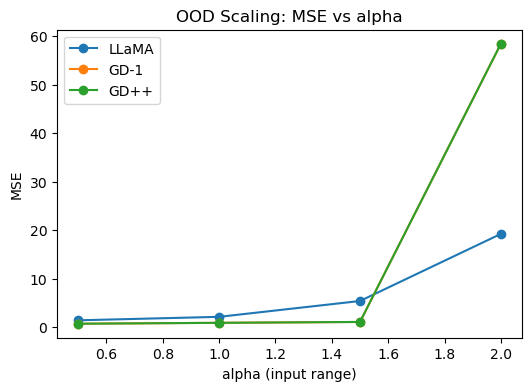

In [57]:

alphas = [0.5, 1.0, 1.5, 2.0]
alpha_results = []
for a in alphas:
    res_a = eval_linear_suite(
        n_tasks=10, d=10, N=10, alpha=a,
        eta_gd=tune["eta"], use_gdpp=True, gamma=tune["gamma"],
        temperature=0.0, do_sensitivity=False
    )
    res_a["alpha"] = a
    alpha_results.append(res_a)

plt.figure(figsize=(6,4))
plt.plot(alphas, [r["MSE_llama"] for r in alpha_results], marker="o", label="LLaMA")
plt.plot(alphas, [r["MSE_gd1"] for r in alpha_results], marker="o", label="GD-1")
plt.plot(alphas, [r["MSE_gdpp"] for r in alpha_results], marker="o", label="GD++")
plt.xlabel("alpha (input range)")
plt.ylabel("MSE")
plt.title("OOD Scaling: MSE vs alpha")
plt.legend()
plt.show()



## 7.Nonlinear sine tasks (Expected to show large error)
We can also test whether the model behaves sensibly on smooth nonlinear targets.


In [13]:

@dataclass
class SineTask:
    A: float
    B: float
    C: float
    X: np.ndarray      # (N, 1)
    y: np.ndarray      # (N, )
    x_test: float
    y_test: float

def sample_sine_task(N: int = 10, alpha: float = 1.0) -> SineTask:
    A = np.random.uniform(0.5, 1.5)
    B = np.random.uniform(0.5, 2.0)
    C = np.random.uniform(0.0, np.pi)
    X = np.random.uniform(-alpha, alpha, size=(N, 1))
    y = A * np.sin(B * X.reshape(-1) + C)
    x_test = float(np.random.uniform(-alpha, alpha))
    y_test = float(A * np.sin(B * x_test + C))
    return SineTask(A=A, B=B, C=C, X=X, y=y, x_test=x_test, y_test=y_test)

def build_prompt_sine(task: SineTask) -> str:
    lines = [f"({task.X[i,0]:.6f}) -> {task.y[i]:.6f}" for i in range(task.X.shape[0])]
    ctx = "\n".join(lines)
    prompt = (
        "You are solving a noiseless regression task where y is a smooth function of x.\n"
        "Given training pairs (x -> y), predict y for the query x_test.\n\n"
        + ctx + "\n\n"
        + f"x_test = {task.x_test:.6f}\n"
        + "Return only a single number (or JSON {\"y\": <number>})."
    )
    return prompt

def eval_sine_suite(n_tasks: int = 10, N: int = 10, alpha: float = 1.0, temperature: float = 0.0):
    gt_list, llama_list = [], []
    fails = 0
    for _ in range(n_tasks):
        t = sample_sine_task(N=N, alpha=alpha)
        p = build_prompt_sine(t)
        _, pred = llama_predict(p, temperature=temperature)
        if pred is None or not np.isfinite(pred):
            fails += 1
            continue
        gt_list.append(t.y_test); llama_list.append(pred)
    return {
        "MSE_llama": mse(llama_list, gt_list) if llama_list else float("nan"),
        "failures": fails,
        "evaluated": len(gt_list)
    }

sine_res = eval_sine_suite(n_tasks=10, N=10, alpha=1.0, temperature=0.0)
print("Sine task results:", sine_res)


Sine task results: {'MSE_llama': 499287.75745792844, 'failures': 0, 'evaluated': 10}


In [8]:

# Import additional required packages
from torch.utils.data import Dataset
import torch

class GaussianMixtureDataset(Dataset):
    """Dataset class for generating Gaussian mixture data"""
    def __init__(self, d: int, N: int, B: int, R: float, is_validation: bool=False, label_flip_p: float =0.0):
        self.d = d
        self.N = N 
        self.B = B
        self.R = R
        self.is_validation = is_validation
        self.label_flip_p = label_flip_p
        assert 0 <= label_flip_p < 0.5, f'label flip probab must be in [0,1/2), got {label_flip_p}'

        if is_validation:
            # use different seed for validation data
            torch.manual_seed(42)
        
        # Generate all data at once and store in tensors
        self.context_x, self.context_y, self.target_x, self.target_y = self._generate_data()
    
    def _generate_data(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Generate all data at once and return fixed tensors.
        """
        # Generate mean vectors for all tasks - Shape: (B, d)
        mus = torch.randn(self.B, self.d)
        # Normalize and scale - Shape: (B, d)
        mus = mus / torch.norm(mus, dim=1, keepdim=True) * self.R
        
        # Generate clean labels at once - Shape: (B, N+1)
        y_all = (torch.rand(self.B, self.N + 1) > 0.5).float()
        
        # Convert to {-1, 1} for signal generation - Shape: (B, N+1)
        y_signal = 2 * y_all - 1
        
        # Generate noise - Shape: (B, N+1, d)
        z = torch.randn(self.B, self.N + 1, self.d)
        
        # Create the mixture - Shape: (B, N+1, d)
        x = y_signal[..., None] * mus[:, None, :] + z

        # Flip labels with probability label_flip_p
        if self.label_flip_p:
            flip_mask = (torch.rand(self.B, self.N + 1) < self.label_flip_p)
            y_all = torch.where(flip_mask, 1 - y_all, y_all)
        
        # Split into context and target
        context_x = x[:, :self.N, :]  # (B, N, d)
        target_x = x[:, -1, :]        # (B, d)
        context_y = y_all[:, :self.N]  # (B, N)
        target_y = y_all[:, -1]       # (B)
        
        return context_x, context_y, target_x, target_y
    
    def __len__(self) -> int:
        return 1  # Only one batch for full-batch GD
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Return the entire dataset as one batch"""
        assert idx == 0, "Only one batch supported for full-batch GD"
        return self.context_x, self.context_y, self.target_x, self.target_y

In [12]:
def format_gmm_example(x: torch.Tensor, y: float) -> str:
    """Format a single example from the GMM dataset for the prompt"""
    x_str = ", ".join(f"{v:.6f}" for v in x.tolist())
    return f"({x_str}) -> Class {int(y)}"

def build_prompt_gmm(context_x: torch.Tensor, context_y: torch.Tensor, 
                    target_x: torch.Tensor, batch_idx: int = 0) -> str:
    """
    Build a prompt for the GMM classification task.
    
    Args:
        context_x: Shape (B, N, d)
        context_y: Shape (B, N)
        target_x: Shape (B, d)
        batch_idx: Which batch example to use
    """
    header = "You are solving a binary classification task.\n"
    header += "Each input x is a point in d-dimensional space, labeled as Class 0 or Class 1.\n"
    header += "Given the training examples, predict the class (0 or 1) for the new point.\n\n"
    
    # Format context examples
    lines = [format_gmm_example(context_x[batch_idx, i], context_y[batch_idx, i]) 
            for i in range(context_x.size(1))]
    ctx = "\n".join(lines)
    
    # Format target
    x_test = ", ".join(f"{v:.6f}" for v in target_x[batch_idx].tolist())
    
    prompt = (
        header
        + "Training examples (each line is '(x1, ..., xd) -> Class y'):\n"
        + ctx + "\n\n"
        + f"Now predict the class for x_test = [{x_test}].\n"
        + "Respond with a single number (0 or 1) or JSON: {\"class\": 0/1}"
    )
    return prompt

@torch.no_grad()
def eval_gmm_llama(dataset: GaussianMixtureDataset) -> Dict[str, float]:
    """Evaluate LLaMA model on GMM classification tasks."""
    context_x, context_y, target_x, target_y = dataset[0]
    
    accuracies = []
    for i in range(dataset.B):
        prompt = build_prompt_gmm(context_x, context_y, target_x, batch_idx=i)
        output, pred = llama_predict(prompt)
        if pred is not None:
            pred = round(float(pred))
            correct = int(pred == target_y[i].item())
            accuracies.append(correct)
    
    return {
        "accuracy": np.mean(accuracies) if accuracies else float("nan"),
        "n_evaluated": len(accuracies),
        "n_failed": dataset.B - len(accuracies)
    }

@torch.no_grad()
def eval_gmm_linear(dataset: GaussianMixtureDataset, linear_model: LinearTransformer) -> Dict[str, float]:
    """Evaluate LinearTransformer model on GMM classification tasks."""
    context_x, context_y, target_x, target_y = dataset[0]
    
    accuracies = []
    in_context_accuracies = []
    
    for i in range(dataset.B):
        # Prepare batch
        batch_x = context_x[i:i+1].to(device)
        batch_y = context_y[i:i+1].to(device)
        batch_target = target_x[i:i+1].to(device)
        
        # Get prediction
        logits = linear_model(batch_x, batch_y, batch_target)
        pred = (logits > 0).float().item()
        correct = int(pred == target_y[i].item())
        accuracies.append(correct)
        
        # Get in-context predictions
        in_context_preds = linear_model.compute_in_context_preds(batch_x, batch_y)
        in_context_acc = (in_context_preds == batch_y).float().mean().item()
        in_context_accuracies.append(in_context_acc)
    
    return {
        "accuracy": np.mean(accuracies),
        "in_context_accuracy": np.mean(in_context_accuracies),
        "n_evaluated": len(accuracies),
        "n_failed": 0
    }

NameError: name 'LinearTransformer' is not defined

In [ ]:
@torch.no_grad()
def eval_gmm_llama(dataset: GaussianMixtureDataset) -> Dict[str, float]:
    """Evaluate LLaMA model on GMM classification tasks."""
    context_x, context_y, target_x, target_y = dataset[0]
    
    accuracies = []
    predictions = []
    true_labels = []
    
    for i in range(dataset.B):
        # Create a more explicit prompt for binary classification
        prompt = (
            "You are performing binary classification. Your task is to predict either class 0 or class 1.\n"
            "For each input point x, you must output EXACTLY 0 or 1.\n\n"
            "Training examples (format: 'input -> class'):\n"
        )
        
        # Add context examples
        for j in range(context_x.size(1)):
            x_str = ", ".join(f"{v:.4f}" for v in context_x[i, j])
            y = int(context_y[i, j].item())
            prompt += f"[{x_str}] -> {y}\n"
        
        # Add target example with very explicit instruction
        x_test_str = ", ".join(f"{v:.4f}" for v in target_x[i])
        prompt += f"\nPredict the class (0 or 1) for: [{x_test_str}]\n"
        prompt += "Output ONLY the number 0 or 1 with no other text.\n"
        
        # Get prediction from model
        input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(device)
        output = llama_model.generate(  # Using llama_model instead of model
            **input_ids,
            max_new_tokens=8,  # We only need a very short response
            temperature=0.0,
            top_p=1.0,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )
        text = tokenizer.decode(output[0][input_ids["input_ids"].shape[1]:], skip_special_tokens=True).strip()
        
        # Parse output, being very strict about valid responses
        try:
            pred_str = text.strip().split()[0]  # Take first token only
            if pred_str in ['0', '1']:
                pred = int(pred_str)
                correct = int(pred == target_y[i].item())
                accuracies.append(correct)
                predictions.append(pred)
                true_labels.append(target_y[i].item())
            else:
                print(f"Invalid prediction '{text}' - expected 0 or 1")
        except Exception as e:
            print(f"Failed to parse model output: '{text}'")
    
    return {
        "accuracy": np.mean(accuracies) if accuracies else float("nan"),
        "predictions": predictions,
        "true_labels": true_labels,
        "n_evaluated": len(accuracies),
        "n_failed": dataset.B - len(accuracies),
        "raw_outputs": []  # For debugging if needed
    }

In [11]:
def eval_gmm_linear(dataset, linear_model):
    """Evaluate LinearTransformer on GMM classification task"""
    results = {
        'accuracy': 0.0,
        'predictions': [],
        'true_labels': []
    }
    
    total_correct = 0
    total_samples = 0
    
    for batch_idx in range(len(dataset)):
        x_context, y_context, x_target, y_target = dataset[batch_idx]
        
        # Move data to device
        x_context = x_context.to(device)
        y_context = y_context.to(device)
        x_target = x_target.to(device)
        y_target = y_target.to(device)
        
        # Forward pass
        with torch.no_grad():
            predictions = linear_model(x_context, y_context, x_target)
            
            # Convert logits to binary predictions (threshold at 0.5)
            binary_preds = (torch.sigmoid(predictions) > 0.5).float()
            
            # Calculate accuracy
            correct = (binary_preds == y_target).sum().item()
            total_correct += correct
            total_samples += len(y_target)
            
            # Store predictions and true labels
            results['predictions'].extend(binary_preds.cpu().numpy().tolist())
            results['true_labels'].extend(y_target.cpu().numpy().tolist())
    
    # Calculate final accuracy
    results['accuracy'] = total_correct / total_samples
    return results

In [ ]:
# Test the GMM classification setup with modified parameters
import json

# Parameters from the paper, with adjustments
d = 20      # dimension
N = 20      # reduced context size (was 41)
B = 10      # batch size
R = 10.0    # increased signal-to-noise ratio (was 3.0)

print("Testing GMM Classification with different Signal-to-Noise Ratios (R)")
print("=" * 70)

# Try two different signal-to-noise ratios
snr_values = [10.0, 20.0]
for R in snr_values:
    print(f"\nSignal-to-Noise Ratio (R) = {R}")
    print("-" * 40)
    
    # Create fresh dataset for this SNR
    dataset = GaussianMixtureDataset(d=d, N=N, B=B, R=R, is_validation=False)
    
    # Create linear transformer model (with a clear name)
    linear_transformer = LinearTransformer(d=d).to(device)
    
    # Test both models
    print("\nEvaluating LLaMA model...")
    llama_results = eval_gmm_llama(dataset)
    
    # Print detailed results for first few examples
    print("\nDetailed LLaMA Results (first 3 examples):")
    for i in range(min(3, len(llama_results["predictions"]))):
        print(f"Example {i + 1}:")
        print(f"Predicted: {llama_results['predictions'][i]}")
        print(f"True Label: {llama_results['true_labels'][i]}")
        print(f"Correct: {llama_results['predictions'][i] == llama_results['true_labels'][i]}\n")
    
    print("Overall LLaMA Results:", json.dumps(llama_results, indent=2))
    
    print("\nEvaluating Linear Transformer...")
    linear_results = eval_gmm_linear(dataset, linear_transformer)
    print("Linear Transformer Results:", json.dumps(linear_results, indent=2))
    
    # Print summary comparison
    print("\nAccuracy Comparison:")
    print(f"LLaMA Accuracy: {llama_results['accuracy']:.3f}")
    print(f"Linear Transformer Accuracy: {linear_results['accuracy']:.3f}")

Testing GMM Classification with different Signal-to-Noise Ratios (R)

Signal-to-Noise Ratio (R) = 10.0
----------------------------------------

Evaluating LLaMA model...


AttributeError: 'LinearTransformer' object has no attribute 'generate'

# Linear Classification Implementation
Below we implement a linear classification version similar to the paper's approach.

In [14]:
import torch
import torch.nn as nn

@dataclass
class LinearClassificationTask:
    W: np.ndarray         # shape: (1, d)
    X: np.ndarray         # shape: (N, d)
    y: np.ndarray         # shape: (N,)  # binary labels 0/1
    x_test: np.ndarray    # shape: (d,)
    y_test: float         # scalar (0 or 1)

def sample_linear_classification_task(
    d: int = D_DEFAULT,
    N: Optional[int] = None,
    alpha: float = 1.0,
    rng: Optional[np.random.Generator] = None,
) -> LinearClassificationTask:
    """
    Sample a binary classification task:
        y = 1 if W·x > 0 else 0,  x ~ U(-alpha, alpha)^d
    """
    if rng is None:
        rng = rng_global
    if N is None:
        N = 2 * d + 1

    # Teacher weights
    W = rng.standard_normal(size=(1, d))
    
    # Context inputs
    X = rng.uniform(-alpha, alpha, size=(N, d))
    # Binary labels based on sign of W·x
    y = (X @ W.T > 0).reshape(-1).astype(float)
    
    # Query example
    x_test = rng.uniform(-alpha, alpha, size=(d,))
    y_test = float(W @ x_test > 0)

    return LinearClassificationTask(W=W, X=X, y=y, x_test=x_test, y_test=y_test)

class LinearTransformer(nn.Module):
    """One-layer linear transformer model for binary classification"""
    def __init__(self, d: int):
        super().__init__()
        self.W = nn.Parameter(torch.zeros(d, d))

    def _predict_single(self, context_x: torch.Tensor, context_y: torch.Tensor, 
                       target_x: torch.Tensor) -> torch.Tensor:
        N = context_x.shape[1]
        context_y_signal = 2 * context_y - 1
        context_term = (1/N) * torch.sum(context_y_signal[..., None] * context_x, dim=1)
        transformed = context_term @ self.W
        logits = (transformed * target_x).sum(dim=1)
        return logits

    def forward(self, context_x: torch.Tensor, context_y: torch.Tensor, 
                target_x: torch.Tensor) -> torch.Tensor:
        return self._predict_single(context_x, context_y, target_x)

    def compute_in_context_preds(self, context_x: torch.Tensor, 
                                context_y: torch.Tensor) -> torch.Tensor:
        B, N, d = context_x.shape
        context_x = context_x / torch.norm(context_x, dim=2, keepdim=True)
        context_y_signal = 2 * context_y - 1
        hat_mu = (1/N) * torch.sum(context_y_signal[..., None] * context_x, dim=1)
        transformed = hat_mu @ self.W
        logits = transformed[:, None, :] @ context_x.transpose(-1, -2)
        predictions = (logits[:, 0, :] > 0).float()
        return predictions

In [15]:
# Example usage
linear_transformer = LinearTransformer(d=D_DEFAULT).to(device)

def eval_classification_task(task: LinearClassificationTask, linear_transformer: LinearTransformer) -> Dict[str, float]:
    # Convert numpy arrays to torch tensors
    context_x = torch.FloatTensor(task.X).unsqueeze(0).to(device)  # Add batch dimension
    context_y = torch.FloatTensor(task.y).unsqueeze(0).to(device)
    target_x = torch.FloatTensor(task.x_test).unsqueeze(0).to(device)
    
    # Get model prediction
    with torch.no_grad():
        logits = linear_transformer(context_x, context_y, target_x)
        pred = (logits > 0).float().item()
    
    # Compute accuracy
    correct = int(pred == task.y_test)
    
    # Also get in-context predictions
    in_context_preds = linear_transformer.compute_in_context_preds(context_x, context_y)
    in_context_acc = (in_context_preds == context_y).float().mean().item()
    
    return {
        "accuracy": correct,
        "in_context_accuracy": in_context_acc,
        "prediction": pred,
        "target": task.y_test
    }

# Test on a batch of tasks
n_eval_tasks = 10
results = []
for _ in range(n_eval_tasks):
    task = sample_linear_classification_task(d=D_DEFAULT, N=None, alpha=1.0)
    res = eval_classification_task(task, linear_transformer)
    results.append(res)

# Compute average metrics
avg_metrics = {
    "test_accuracy": np.mean([r["accuracy"] for r in results]),
    "in_context_accuracy": np.mean([r["in_context_accuracy"] for r in results])
}
print("Classification Results:", json.dumps(avg_metrics, indent=2))

Classification Results: {
  "test_accuracy": 0.7,
  "in_context_accuracy": 0.4829268127679825
}


C:\Users\banga\AppData\Local\Temp\ipykernel_21872\104579869.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = float(W @ x_test > 0)
